# Lab 3

This lab continues our study of linear regression. You'll train your first models with Tensorflow, using a real dataset to predict car prices from their features. Note that Tensorflow is a rapidly changing library. This means you'll often see warnings about deprecations. You can ignore the warnings in our labs.

In [ ]:
# Import the libraries we'll use below.
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style
import tensorflow as tf

## Understanding the data
Below, we'll train models using some real data. Here we'll use the [Automobile Data Set](https://archive.ics.uci.edu/ml/datasets/automobile)  from 1985 Ward's Automotive Yearbook that is part of the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets).

But before doing any training (or evaluating), let's make sure we understand what we're working with. 

### Load the data
Load the data using the column names from [Automobile Data Set](https://archive.ics.uci.edu/ml/datasets/automobile). We'll only use a few of the columns so don't worry about understanding what they all mean.

In [ ]:
# Provide the names for the feature columns since the CSV file with the data
# does not have a header row.
cols = ['symboling', 'losses', 'make', 'fuel-type', 'aspiration', 'num-doors',
        'body-style', 'drive-wheels', 'engine-location', 'wheel-base',
        'length', 'width', 'height', 'weight', 'engine-type', 'num-cylinders',
        'engine-size', 'fuel-system', 'bore', 'stroke', 'compression-ratio',
        'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']

# Load the data from a CSV file into a pandas dataframe. Remember that each row
# is an example and each column in a feature.
car_data = pd.read_csv(
    'https://storage.googleapis.com/ml_universities/cars_dataset/cars_data.csv',
    sep=',', names=cols, header=None, encoding='latin-1')

# Display applies built-in formatting for nicer printing, if available.
display(car_data)

### Randomize
Since we'll be using SGD (Stochastic Gradient Descent) for training, it is important that **each batch is a random sample of the data** so that the gradient computed is representative. Note that the original data (above) appears sorted by *make* in alphabetic order.

In [ ]:
# We want to shuffle the order of the rows without touching the columns.
# First, we get a list of indices corresponding to the rows.
indices = np.arange(car_data.shape[0])
print('indices:', indices, '\n')

# Next, we shuffle the indices using np.random.permutation but set a random seed
# so that everyone gets the same results each time.
np.random.seed(0)
shuffled_indices = np.random.permutation(indices)
print('shuffled indices:', shuffled_indices, '\n')

# Finally, we use dataframe.reindex to change the ordering of the original
# dataframe.
car_data = car_data.reindex(shuffled_indices)
display(car_data)

# Note that this could be done in one fancy line:
# car_data = car_data.reindex(np.random.permutation(car_data.shape[0]))

### Feature selection
To keep things simple, we will keep just a few of the 26 columns. Since the values come as strings, we need to convert them to floats. Also, we remove examples (rows) that have some missing value(s) of the columns we care about. Note that in general, there are various ways to deal with missing features, and this strategy of dropping examples with any missing feature is not ideal.

In [ ]:
# Choose a subset of columns (these are all numeric).
columns = ['horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']
car_data = car_data[columns]

# Convert strings to numeric values, coercing missing values to nan.
for column in columns:
  car_data[column] = pd.to_numeric(car_data[column], errors='coerce')

# The dropna function drops rows with missing value(s) by default.
car_data = car_data.dropna()

# This leaves us with 199 examples.
display(car_data)

### Train/Test split
Now that we've shuffled the order, we can split into portions for train and test easily. We'll try to avoid looking at the test data.

We're going to train models that **predict price from the other columns**, so we'll create separate variables for input and output data.


In [ ]:
# We'll use these input features.
features = ['horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg']

# Use a ~80/20 train/test split.
car_train = car_data[:160]
car_test = car_data[160:]

# Create separate variables for features (inputs) and labels (outputs).
# We will be using these in the cells below.
car_train_features = car_train[features]
car_test_features = car_test[features]
car_train_labels = car_train['price']
car_test_labels = car_test['price']

# Confirm the data shapes are as expected.
print('train data shape:', car_train_features.shape)
print('train labels shape:', car_train_labels.shape)
print('test data shape:', car_test_features.shape)
print('test labels shape:', car_test_labels.shape)

---
### Exercise 1: Baseline (8 points)

Now that we have test data, we can evaluate a baseline. We'll use the average price of cars in the training set as our baseline model -- that is, the baseline always predicts the average price regardless of the input. And, instead of MSE, let's use **RMSE** (root mean squared error) -- that is, just take the square root of the MSE -- as our evaluation metric.

1. Implement this baseline.
2. Compute the RMSE of the baseline on both the train and test data.
3. Is the test RMSE larger or smaller than the train RMSE? Explain whether this is what you'd expect.

In [75]:
# YOUR CODE HERE

import math


train_average = car_train_labels.mean()
test_average = car_test_labels.mean()

baseline_train = np.full(shape=160,fill_value=train_average,dtype=np.float64)
baseline_test = np.full(shape=39,fill_value=test_average,dtype=np.float64)

MSE_train = np.square(np.subtract(car_train_labels,baseline_train)).mean() 
 
RMSE_train = math.sqrt(MSE_train)
print("Root Mean Square Error for Train Data:\n")
print(RMSE_train,"\n")

MSE_test = np.square(np.subtract(car_test_labels,baseline_test)).mean()
 
RMSE_test = math.sqrt(MSE_test)
print("Root Mean Square Error for Test Data:\n")
print(RMSE_test)


Root Mean Square Error for Train Data:

7946.598808255962 

Root Mean Square Error for Test Data:

7965.950903945884


*Written answer: RMSE for train and test were relatively close to each other. Given that the datae was split randomly this is expected.

---

### Feature histograms
It's hard to stare at a matrix of 160x5 numbers (the shape of our training data) and know what to make of it. Plotting feature histograms is a good way to start building intuition about the data. This gives us a sense of the distribution of each feature, but not how the features relate to each other.

We can also use the `describe` function to look at some aggregate statistics for the `DataFrame`.

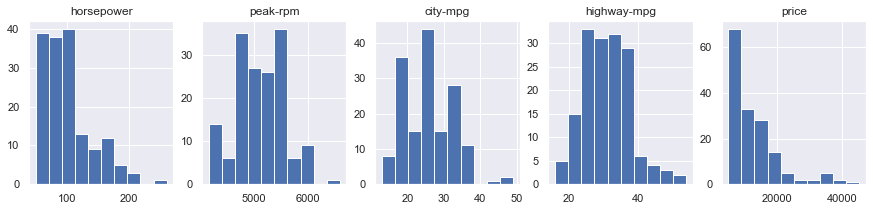

,horsepower,peak-rpm,city-mpg,highway-mpg,price
count,160.000000,160.000000,160.000000,160.000000,160.000000
mean,101.468750,5105.625000,25.493750,31.025000,13064.675000
std,38.227542,467.059162,6.649346,7.106512,7971.548944
min,48.000000,4150.000000,13.000000,16.000000,5118.000000
25%,70.000000,4800.000000,19.000000,25.000000,7609.000000
50%,93.000000,5100.000000,25.000000,30.500000,10320.000000
75%,115.250000,5500.000000,31.000000,37.000000,16500.000000
max,262.000000,6600.000000,49.000000,54.000000,45400.000000


In [76]:
plt.figure(figsize=(15, 3))
for i in range(len(columns)):
  plt.subplot(1, 5, i+1)
  plt.hist(np.array(car_train[columns[i]]))
  plt.title(columns[i])
plt.show()

display(car_train.describe())

---
### Exercise 2: Feature correlations (8 points)

Using pandas [`corr()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html) to print all the pairwise correlation coefficients for the columns (use the training data only). See also the [Wikipedia page on correlation](https://en.wikipedia.org/wiki/Correlation) for more background.

Then answer the following questions:

1. It appears that higher-priced cars have higher or lower fuel efficiency?
1. Which two features are likely to be most redundant?
1. Which feature is likely to be least useful for predicting price?

Extra (ungraded): try using [`sns.pairplot`](https://seaborn.pydata.org/generated/seaborn.pairplot.html) to examine each pair of features.

             horsepower  peak-rpm  city-mpg  highway-mpg     price
horsepower     1.000000  0.104330 -0.815571    -0.798128  0.829328
peak-rpm       0.104330  1.000000 -0.140634    -0.084458 -0.082567
city-mpg      -0.815571 -0.140634  1.000000     0.973606 -0.695344
highway-mpg   -0.798128 -0.084458  0.973606     1.000000 -0.703647
price          0.829328 -0.082567 -0.695344    -0.703647  1.000000


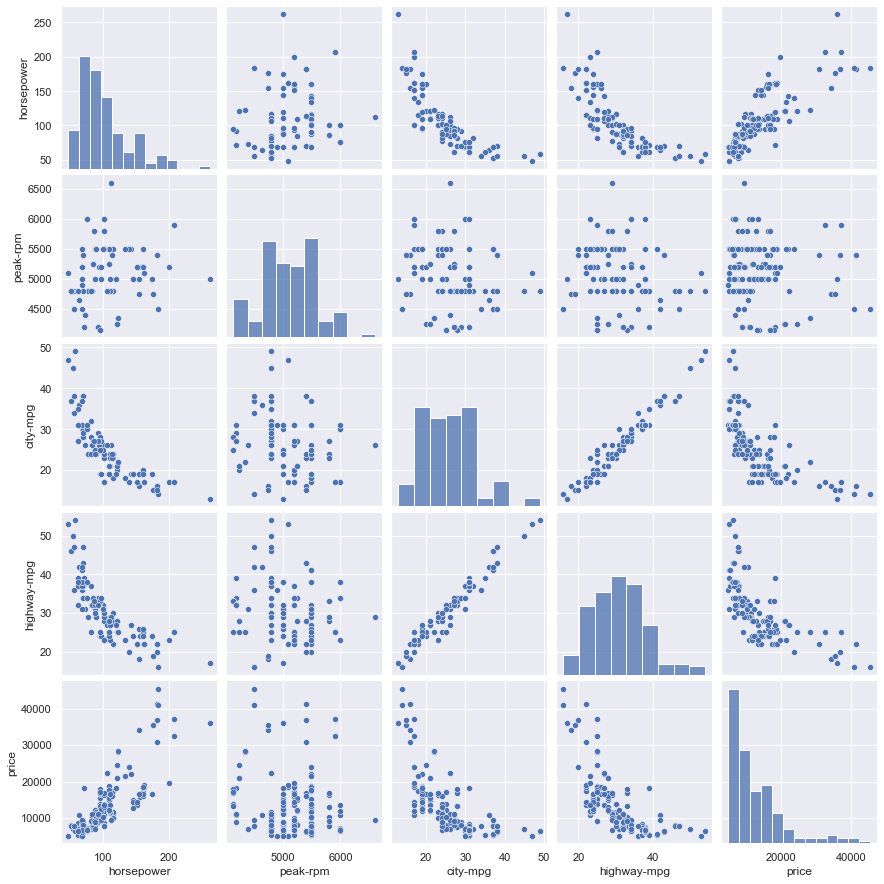

In [77]:
print(car_train.corr(method="pearson"))

print(sns.pairplot(car_train))

*Written answer:*

1. Higher priced cars have lower fuel efficiency
2. city-mpg and highway-mpg
3. peak-rpm and prive have correlation closest to zero.

---

## Tensorflow

Let's train a linear regression model much like we did in the previous assignment, but this time using Tensorflow. Tensorflow is a powerful library with a complicated API so it is easy to get overwhelmed. We'll try to keep it simple.

### Build a model
Here's how you use Tensorflow: First, you build a *computational graph*, and then you send data through it.

This is confusing, but you'll get used to it. The computational graph for linear regression is very simple. There are many ways to build graphs, but the [Keras library](https://www.tensorflow.org/api_docs/python/tf/keras) is recommended. Here, we're using [`keras.layers.Dense`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) to create a model layer. We will go over Tensorflow and Keras in more detail, so don't worry about understanding everything now.

In [78]:
def build_model(num_features, learning_rate):
  """Build a TF linear regression model using Keras.

  Args:
    num_features: The number of input features.
    learning_rate: The desired learning rate for SGD.

  Returns:
    model: A tf.keras model (graph).
  """
  # This is not strictly necessary, but each time you build a model, TF adds
  # new nodes (rather than overwriting), so the colab session can end up
  # storing lots of copies of the graph when you only care about the most
  # recent. Also, as there is some randomness built into training with SGD,
  # setting a random seed ensures that results are the same on each identical
  # training run.
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  # Build a model using keras.Sequential. While this is intended for neural
  # networks (which may have multiple layers), we want just a single layer for
  # linear regression.
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Dense(
      units=1,                     # output dim
      input_shape=[num_features],  # input dim
      use_bias=True,               # use a bias (intercept) param
      kernel_initializer=tf.ones_initializer,  # initialize params to 1
      bias_initializer=tf.ones_initializer,    # initialize bias to 1
  ))

  # We need to choose an optimizer. We'll use SGD, which is actually mini-batch
  # SGD. We can specify the batch size to use for training later.
  optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

  # Finally, we compile the model. This finalizes the graph for training.
  # We specify the MSE loss.
  model.compile(loss='mse', optimizer=optimizer)
  return model

After we've built a model, we can inspect the initial parameters (weights). There should be two ($w_0$ and $b$) and they should be initialized to 1, which we specified above using `tf.ones_initializer`. Unlike our code in the last assignment, Tensorflow stores the bias/intercept separately from the other weights/parameters for the layer. We also don't need to prepend a column of 1s to learn the bias -- Tensorflow handles this for us.

In [79]:
# Build a model.
model = build_model(num_features=1, learning_rate=0.0001)

# Use get_weights() which returns lists of weights and biases for the layer.
weights, biases = model.layers[0].get_weights()
print('Weights:', weights)
print('Biases:', biases)

Weights: [[1.]]
Biases: [1.]


Let's also try building a model with 2 features. Notice that in both cases, the weights are 2-D while the biases are 1-D.

In [80]:
# Build a model and look at the initial parameter values.
model = build_model(num_features=2, learning_rate=0.0001)
weights, biases = model.layers[0].get_weights()
print('Weights:', weights)
print('Biases:', biases)

Weights: [[1.]
 [1.]]
Biases: [1.]


### Making predictions
Wait, we haven't trained yet! Why are we talking about making predictions? Well, remember that a model is a computational graph. That means we can pass data (of the expected shape) through the model (using the current values of the parameters) to make predictions.

Before training, the parameters are set to their initial values (1s in our case). During training, we use the current predictions to compute a gradient and update the parameter values. Making predictions using the model without updating parameter values is called **Inference**.

In the example code below, make sure you understand the output of `predict`.

In [81]:
# Build a model that expects 1 input feature.
model = build_model(num_features=1, learning_rate=0.0001)

# Make a prediction for a single input.
print(model.predict([42]))

# Make predictions for 2 inputs.
print(model.predict([42, 99]))

[[43.]]
[[ 43.]
 [100.]]


### Train a model
Now let's actually train a model, initially with just 1 feature -- the horsepower. Notice that the `fit` function can take pandas DataFrame objects for input (x) and output (y). In addition, we can convert the return value into a DataFrame that tracks training metrics (in this case, training data loss and validation data loss) after each *epoch* (a full pass through the training data).

Remember that we're using SGD, which is actually mini-batch SGD. That is, each time the model estimates the loss for the current weights, it randomly samples a batch of training examples (of the specified size) to do so.

Finally, we'll reserve some more examples (taken out of the training set) as a *validation set*. We use this data to check for overfitting while training. Why not use the *test set* for this purpose? We want to maintain the purity of the test set so we try to only use it at the end of the experimental process.

In [82]:
model = build_model(num_features=1, learning_rate=0.0001)

history = model.fit(
  x = car_train_features[['horsepower']],
  y = car_train_labels,
  validation_split=0.1,  # use 10% of the examples as a validation set
  epochs=5,
  batch_size=32,
  verbose=0)

# Convert the return value into a DataFrame so we can see the loss after each
# epoch. The history includes training data loss ('loss') and validation data
# loss ('val_loss').
history = pd.DataFrame(history.history)
display(history)

,loss,val_loss
0,9.451236e+08,2.757709e+09
1,1.157148e+10,2.634771e+10
2,8.129331e+10,3.772780e+11
3,1.176510e+12,3.559108e+12
4,5.976482e+12,3.931731e+13


### Feature scaling
The loss is increasing as we train! What's going wrong?

Look back at the histograms above. Notice that the scale of each feature value is different. Horsepower ranges from 48 to 262, while price ranges from \$5118 to \$45400. These different scales makes it more difficult to set the learning rate, and may make learning nearly impossible when we use multiple features (the scales of the gradients will overwhelm the actual feature importances).

First, try reducing the learning rate above by 10x to 1e-5. That should fix the problem for now.

But a better solution is to normalize the features so they are all roughly in the same range. We'll do this with mean and variance normalization. That is, for each feature, we subtract the mean (center the distribution on 0) and divide by the standard deviation (set the variance to 1).

---
### Exercise 3: Feature normalization (8 points)

Apply mean and variance normalization to produce car_train_features_norm and car_test_features_norm. These should be copies of the car_train_features and car_test_features, but with normalized feature values. Note that we're not normalizing the labels (prices).

* DataFrame objects have `mean` and `std` functions you can use.
* **Important:** You can't normalize the test data by computing mean and variance on the test data, as this would violate our willful blindness of the test data.
* Use the `describe` function (as above) to verify your normalized data looks right.

In [83]:
# YOUR CODE HERE

# Since the question asks for mean and variance I'm assuming we need to standardize the features  - and not normalize them between 0 and 1. 

from sklearn.preprocessing import StandardScaler


car_train_features_norm = StandardScaler()

stdsc = StandardScaler()

car_train_features_norm= stdsc.fit_transform(car_train_features)

car_test_features_norm = stdsc.transform(car_test_features)

car_train_features_norm = pd.DataFrame(car_train_features_norm)

car_train_features_norm.columns = features


print(car_train_features_norm_df.describe())



car_test_features_norm = pd.DataFrame(car_test_features_norm)

car_test_features_norm.columns = features

print(car_test_features_norm_df.describe())



                  0             1             2             3
count  1.600000e+02  1.600000e+02  1.600000e+02  1.600000e+02
mean  -1.457168e-17  1.387779e-18  2.081668e-16  1.831868e-16
std    1.003140e+00  1.003140e+00  1.003140e+00  1.003140e+00
min   -1.403089e+00 -2.052471e+00 -1.884844e+00 -2.120896e+00
25%   -8.257804e-01 -6.564149e-01 -9.796661e-01 -8.504758e-01
50%   -2.222309e-01 -1.208126e-02 -7.448857e-02 -7.410785e-02
75%    3.616377e-01  8.470302e-01  8.306890e-01  8.434179e-01
max    4.212546e+00  3.209587e+00  3.546222e+00  3.243101e+00
               0          1          2          3
count  39.000000  39.000000  39.000000  39.000000
mean    0.258186   0.131104  -0.225351  -0.246031
std     0.891394   1.151179   0.827035   0.781215
min    -1.088193  -1.945082  -1.583118  -1.838581
25%    -0.458402  -0.656415  -0.979666  -0.850476
50%     0.328836   0.202697  -0.225351  -0.144687
75%     0.722455   0.847030   0.227237   0.208208
max     2.769275   3.209587   1.886729   1

### Training with features
We're ready to run some experiments with different sets of input features. To start, here's a simple function that plots train and validation set loss.

In [84]:
def plot_loss(model, history):
  """Plot the loss after each training epoch."""
  # Convert the history object into a DataFrame.
  history = pd.DataFrame(history.history)

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.plot(range(len(history)), history['loss'], marker='.', color='black')
  plt.plot(range(len(history)), history['val_loss'], marker='.', color='red')
  plt.legend(['train loss', 'validation loss'])
  plt.show()

  # Show the final train loss value and the learned model weights.
  print('Final train loss:', list(history['loss'])[-1])
  print('Final weights:', model.layers[0].get_weights())

---
### Exercise 4: Adjusting learning rate (8 points)

Retrain the model predicting price from horsepower, but now using your normalized features. Report validation loss for learning rates [0.0001, 0.001, 0.01, 0.1, 1] after 150 epochs of training. Which produces the best validation loss?


 Learning rate is:  0.0001


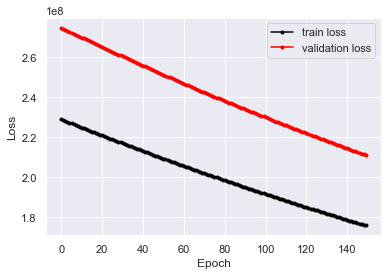

Final train loss: 176007904.0
Final weights: [array([[842.7884]], dtype=float32), array([1813.1615], dtype=float32)]

 Learning rate is:  0.001


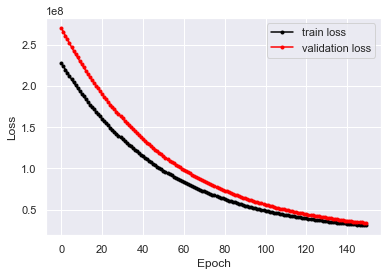

Final train loss: 31002674.0
Final weights: [array([[4898.455]], dtype=float32), array([10132.426], dtype=float32)]

 Learning rate is:  0.01


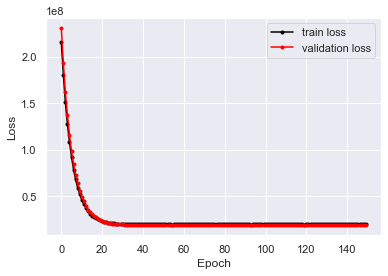

Final train loss: 19829286.0
Final weights: [array([[6515.0923]], dtype=float32), array([13029.896], dtype=float32)]

 Learning rate is:  0.1


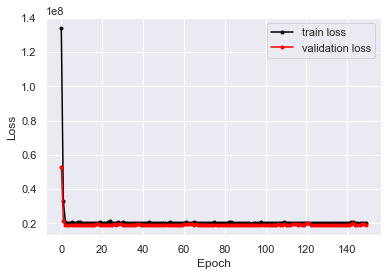

Final train loss: 20099608.0
Final weights: [array([[6454.0103]], dtype=float32), array([12849.252], dtype=float32)]

 Learning rate is:  1


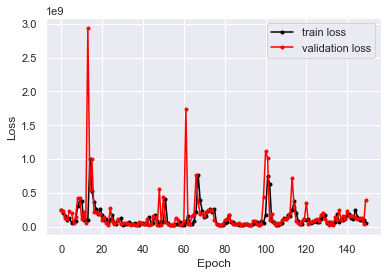

Final train loss: 61302088.0
Final weights: [array([[-6180.914]], dtype=float32), array([3047.7305], dtype=float32)]


In [85]:
# EDIT CODE HERE


learning_rate= [.0001,.001,.01,.1,1]

for l in learning_rate:
    print("\n Learning rate is: ", l)
    model = build_model(num_features=1, learning_rate = l)

    history = model.fit(
      # use the normalized features prepared above
      x = car_train_features_norm[['horsepower']],
      y = car_train_labels,
      validation_split=0.1,
      epochs=150,
      batch_size=32,
      verbose=0)

    plot_loss(model, history)

*Written answer:*

The learning rate at 0.01 produces the lowest loss.

---

### Exercise 5: Adding features (8 points)

The goal of this exercise is to compile a table of results -- RMSE computed on the test data for the baseline and 4 models:
1. features = horsepower
2. features = horsepower, peak-rpm
3. features = horsepower, peak-rpm, highway-mpg
4. features = horsepower, peak-rpm, highway-mpg, city-mpg

For consistency, use a batch size of 32, 150 epochs, and the best learning rate you found above.

['horsepower']


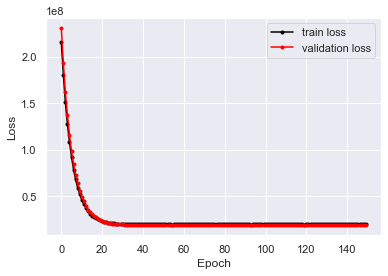

Final train loss: 19829286.0
Final weights: [array([[6515.0923]], dtype=float32), array([13029.896], dtype=float32)]
Test rmse: 5480.30948031222
['horsepower']


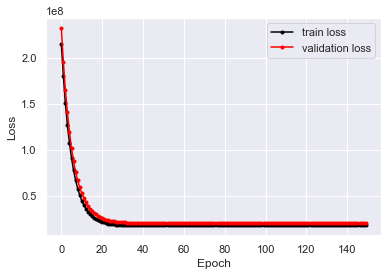

Final train loss: 17721320.0
Final weights: [array([[ 6628.3804],
       [-1477.8821]], dtype=float32), array([13015.373], dtype=float32)]
Test rmse: 5072.53289787262
['horsepower', 'peak-rpm']


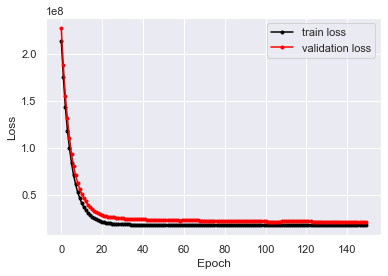

Final train loss: 17487700.0
Final weights: [array([[ 5747.9097],
       [-1550.5641],
       [ -989.6218]], dtype=float32), array([13006.336], dtype=float32)]
Test rmse: 5059.429612120322
['horsepower', 'peak-rpm', 'highway-mpg']


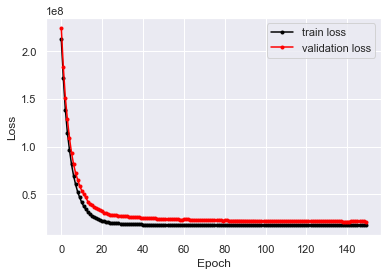

Final train loss: 17292280.0
Final weights: [array([[ 5696.6543  ],
       [-1498.6621  ],
       [   80.326614],
       [-1142.1101  ]], dtype=float32), array([12997.83], dtype=float32)]
Test rmse: 4982.080890551658


In [86]:
# EDIT CODE HERE
def run_experiment(features, learning_rate):
  model = build_model(len(features), learning_rate)

  history = model.fit(
    x = car_train_features_norm[features],
    y = car_train_labels,
    validation_split=0.1,
    epochs=150,
    batch_size=32,
    verbose=0)

  plot_loss(model, history)

  # Make predictions on test data
  test_loss = model.evaluate(car_test_features_norm[features],
                             car_test_labels,
                             verbose=0)
  test_rmse = np.sqrt(test_loss)
  print('Test rmse:', test_rmse)



features = ['horsepower']
print(features)
run_experiment(features, 0.01)
print(features)
features = ['horsepower', 'peak-rpm']
run_experiment(features, 0.01)
print(features)
features = ['horsepower', 'peak-rpm','highway-mpg']
run_experiment(features, 0.01)
print(features)
features = ['horsepower', 'peak-rpm','highway-mpg','city-mpg']
run_experiment(features, 0.01)




*Written answer:*

Model | Test RMSE
--- | ---
Baseline | 7965.95
Horsepower | 5480.31
Add Peak-RPM | 5072.53
Add Highway-PG | 5059.43
Add City-MPG | 4982.08


---

## Review
* The **[Pandas](https://pandas.pydata.org/) library** is very useful for manipulating datasets and works well with numpy.
* Use a random split into train and test data and measure performance on the test data, starting from a simple **baseline**.
* Examine data using histograms and correlations to help build intuition before training any models.
* **Tensorflow** works by first building a **computational graph**; then, you can pass data through the graph to produce predictions, updating parameters via gradient descent in training mode; we use the **Keras API** to easily configure models.
* Training is often quite sensitive to the **learning rate** hyperparameter, and feature normalization is an important strategy to avoid differences in the scale of the feature derivatives (gradient) that can make learning impossible.